In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *
import utils.vision_transformer as VT

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

## Compute Model Parameters (Spectrogram Shape)

In [2]:
file_path = "./data/10P/test/walk_0514_1043.csv"

# 1-D spectrogram
# window_size=128
# stride=64
# nperseg=128
# noverlap=64
# out1=True

# 2-D spectrogram
window_size=256
stride=64
nperseg=128
noverlap=64
out1=True
byCol=True
sp_num = 16

spectrograms_file, gts_file, times_file = prepare_file(file_path, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1, byCol=byCol, sp_num=sp_num)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 133/300
----------------------------
sepctrograms:(24, 16, 65, 3)
gt:(24, 1)
times:(24, 1)


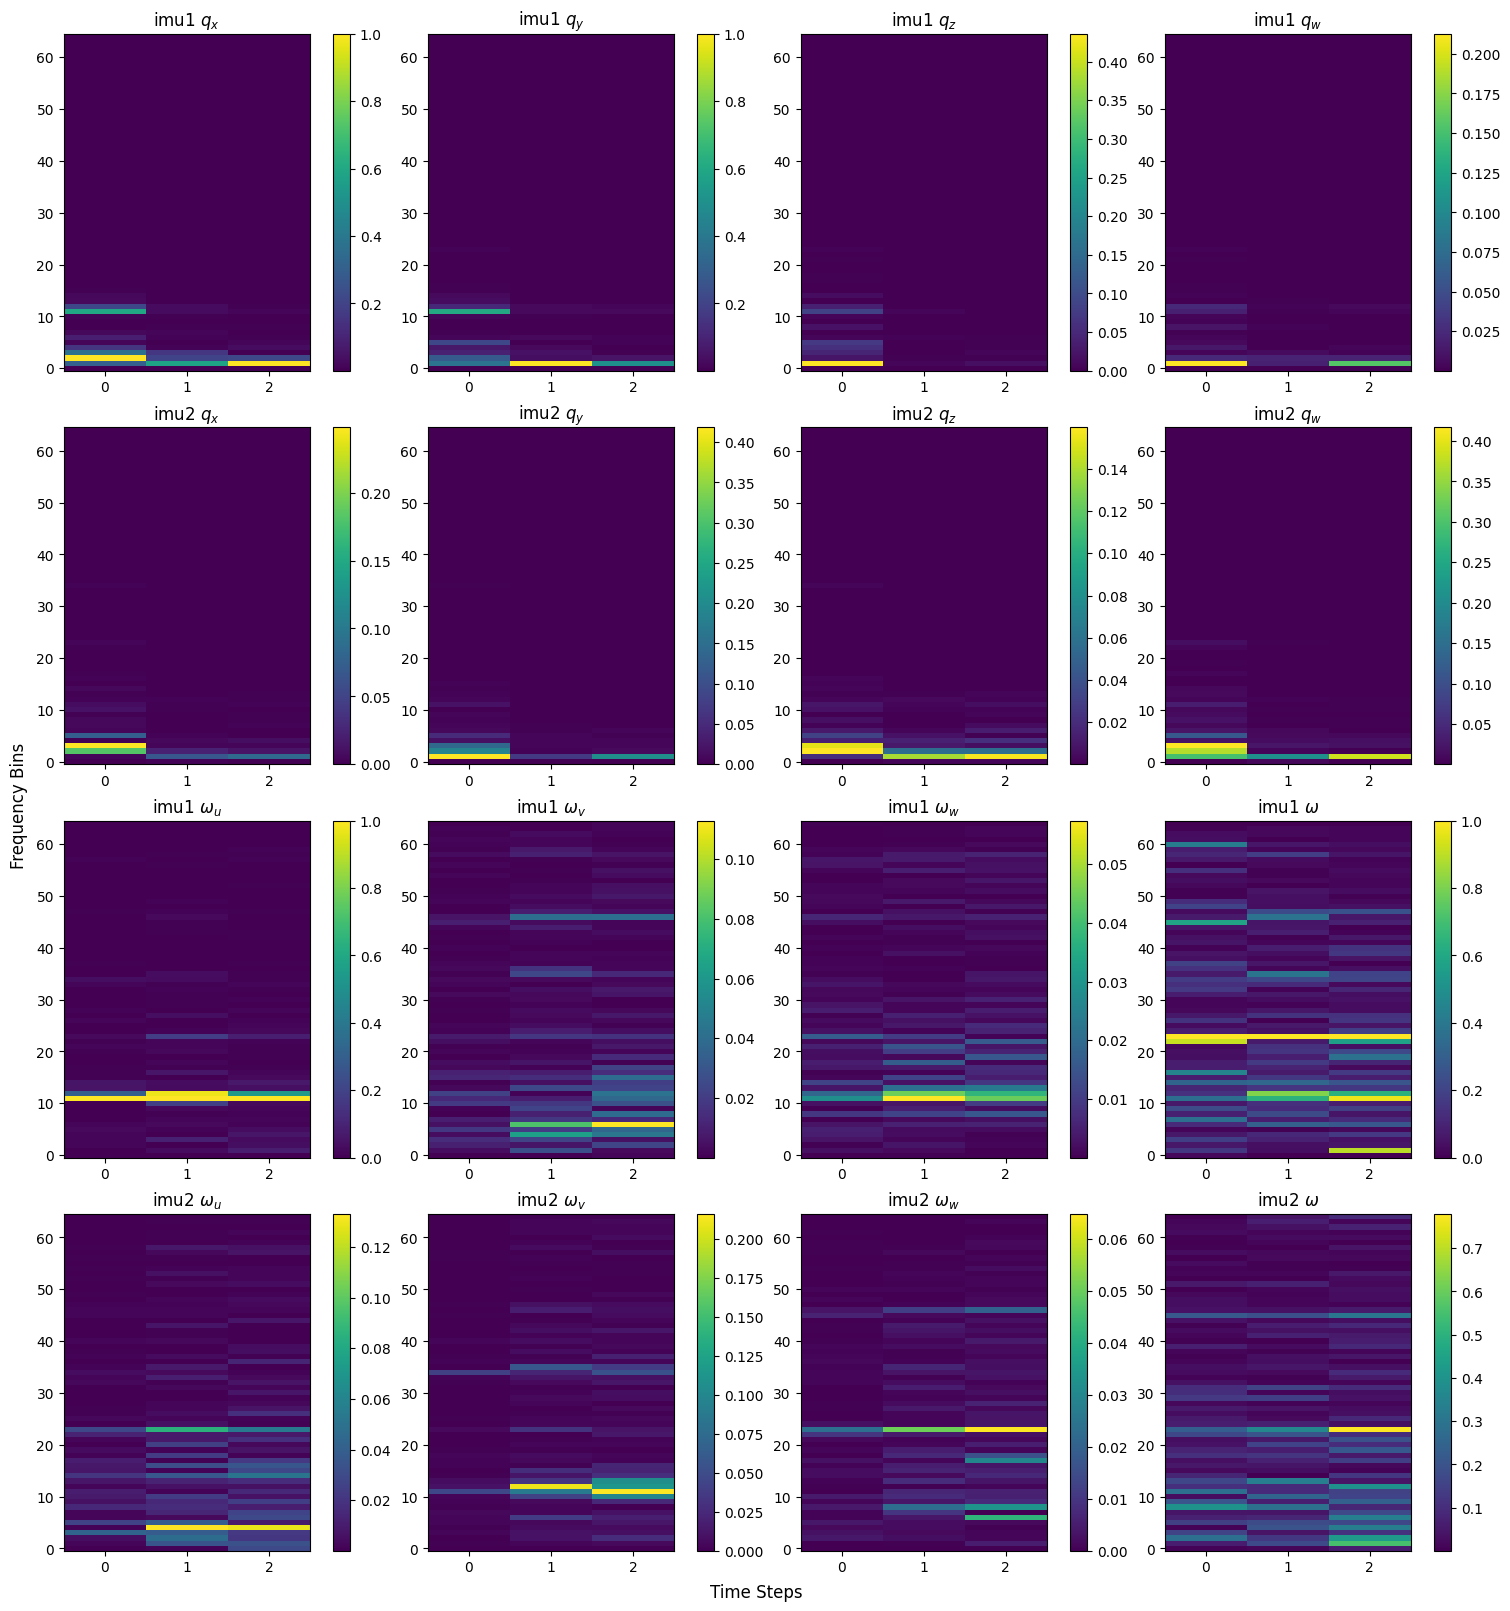

In [3]:
# show one spectrogram
plot_spectrogram_16(spectrograms_file[10])

In [4]:
torch.cuda.is_available()

True

## Testing Model

In [5]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "10P_16"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

Testing data......
Testing shape: (350, 16, 65, 3)


In [6]:
# Test one file
action_name = "walk_0604_0710"
path_file = f'./data/10P/test/{action_name}.csv'

# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True, sp_num=sp_num)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 231/300
----------------------------
sepctrograms:(22, 16, 65, 3)
gt:(22, 1)
times:(22, 1)


In [7]:
# Load models
# 2-D spectrogram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_name = ['MLP_10P_16', 'CNN_10P_16', 'VT_10P_16_emt2', 'VT_10P_16_emht2']
models_name_show = ["MLP", "CNN", "ViT_emt2", "ViT_emht2"]
# models_name_show = ["proposed_1", "proposed_2", "proposed_3", "proposed_4"]

models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, device=device),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=256, mlp_dim=512, num_heads=8, device=device)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_10P_16 Evaluation Results - MSE Loss: 0.0036, L1 Loss: 2.6627 1/min
CNN_10P_16 Evaluation Results - MSE Loss: 0.0033, L1 Loss: 2.6678 1/min
VT_10P_16_emt2 Evaluation Results - MSE Loss: 0.0030, L1 Loss: 2.4289 1/min
VT_10P_16_emht2 Evaluation Results - MSE Loss: 0.0026, L1 Loss: 2.3906 1/min


MLP Evaluation Results - MSE Loss: 0.0062, L1 Loss: 4.2937 1/min, R²:-32.4731
CNN Evaluation Results - MSE Loss: 0.0077, L1 Loss: 4.9601 1/min, R²:-40.6075
ViT_emt2 Evaluation Results - MSE Loss: 0.0146, L1 Loss: 7.0022 1/min, R²:-77.6084
ViT_emht2 Evaluation Results - MSE Loss: 0.0095, L1 Loss: 5.7535 1/min, R²:-50.0798


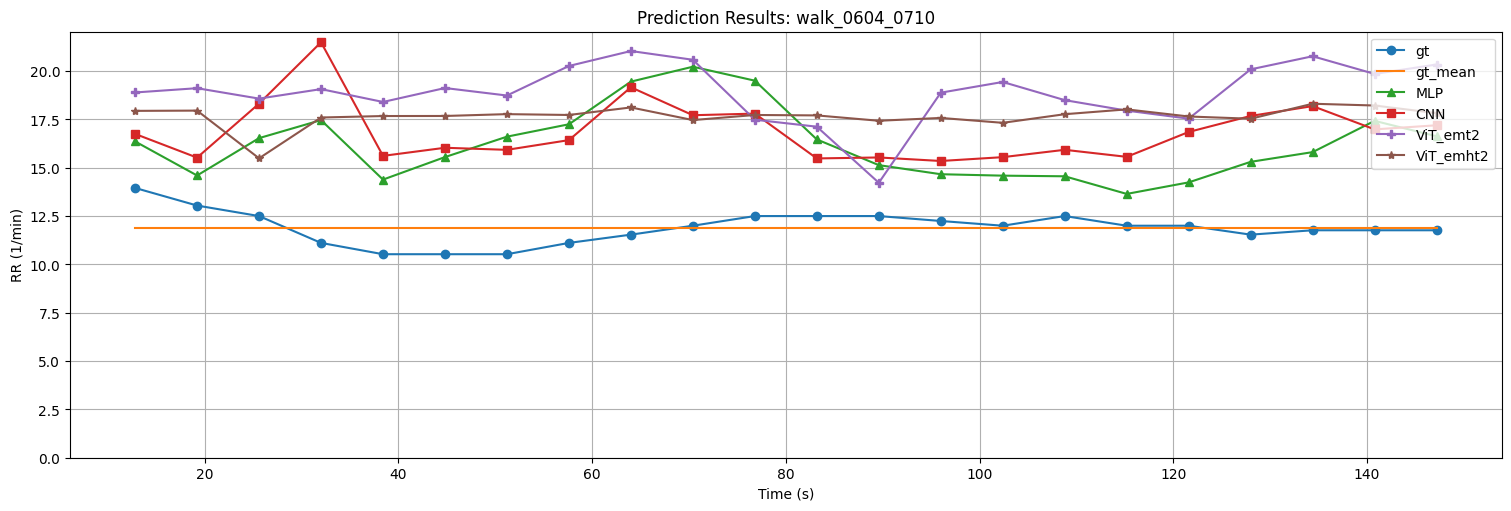

In [8]:
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=models_name_show, gt=gts_file, times=times_file, action_name=action_name)

## Testing Actions

In [9]:
# Load dataset
dataset_dir = "dataset/action"
dataset_name = "10P_16"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_key = next(iter(input_test))
num_channels = input_test[first_key].shape[1]
num_freq_bins = input_test[first_key].shape[2]
num_time_steps = input_test[first_key].shape[3]

action_order = ['sit', 'stand', 'walk', 'run']
input_test = {k : input_test[k] for k in action_order}
gt_test = {k : gt_test[k] for k in action_order}
print('Testing data......')
for k, v in input_test.items():
    print(f'action: {k}')
    # print(f'input_test[{k}]:{input_test[k].shape}')
    # print(f'gt_test[{k}]:{gt_test[k].shape}')

Testing data......
action: sit
action: stand
action: walk
action: run


MLP
sit - MSE Loss: 0.0004, L1 Loss: 1.0364 1/min
stand - MSE Loss: 0.0009, L1 Loss: 1.4179 1/min
walk - MSE Loss: 0.0094, L1 Loss: 5.2646 1/min
run - MSE Loss: 0.0036, L1 Loss: 2.9671 1/min

CNN
sit - MSE Loss: 0.0010, L1 Loss: 1.5998 1/min
stand - MSE Loss: 0.0020, L1 Loss: 2.2425 1/min
walk - MSE Loss: 0.0081, L1 Loss: 4.6810 1/min
run - MSE Loss: 0.0020, L1 Loss: 2.0873 1/min

ViT_emt2
sit - MSE Loss: 0.0004, L1 Loss: 0.9455 1/min
stand - MSE Loss: 0.0016, L1 Loss: 1.8284 1/min
walk - MSE Loss: 0.0078, L1 Loss: 4.6408 1/min
run - MSE Loss: 0.0021, L1 Loss: 2.2794 1/min

ViT_emht2
sit - MSE Loss: 0.0007, L1 Loss: 1.3126 1/min
stand - MSE Loss: 0.0018, L1 Loss: 1.8820 1/min
walk - MSE Loss: 0.0051, L1 Loss: 3.8313 1/min
run - MSE Loss: 0.0027, L1 Loss: 2.5471 1/min



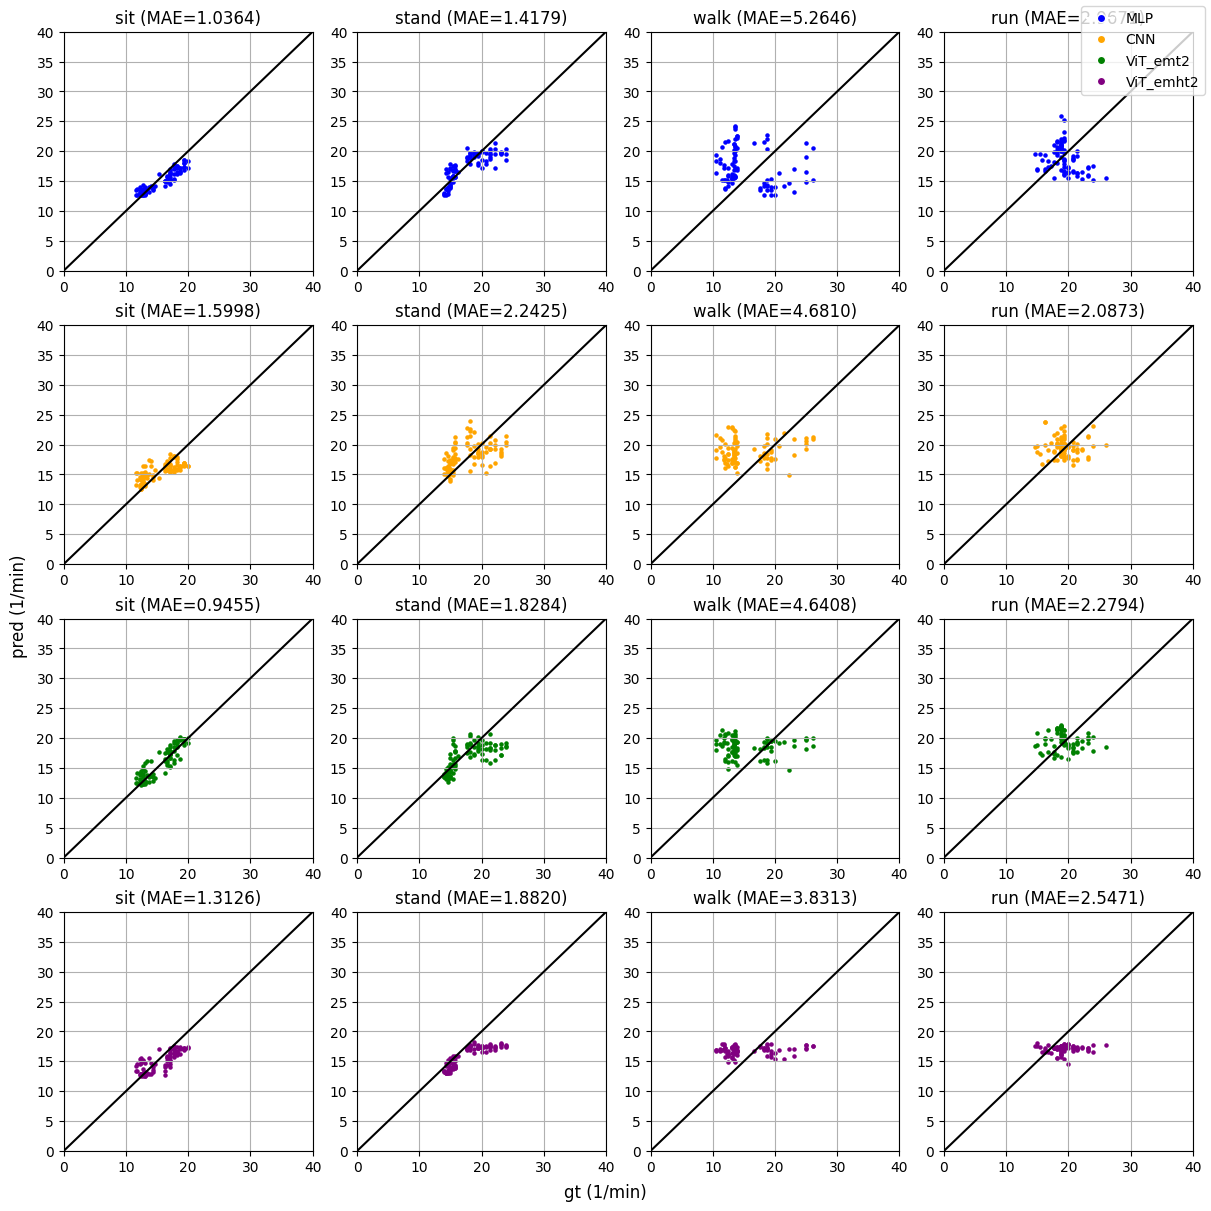

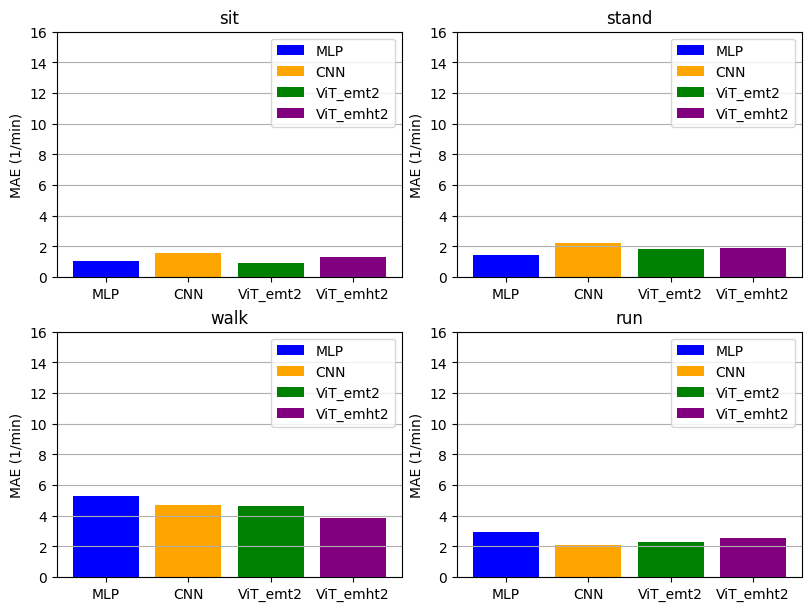

In [10]:
evaluate_models_action(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)

MLP
sit - MSE Loss: 0.0004, L1 Loss: 1.0364 1/min E%: 6.5118%
stand - MSE Loss: 0.0009, L1 Loss: 1.4179 1/min E%: 7.7602%
walk - MSE Loss: 0.0094, L1 Loss: 5.2646 1/min E%: 35.4960%
run - MSE Loss: 0.0036, L1 Loss: 2.9671 1/min E%: 14.9257%

CNN
sit - MSE Loss: 0.0010, L1 Loss: 1.5998 1/min E%: 10.6464%
stand - MSE Loss: 0.0020, L1 Loss: 2.2425 1/min E%: 12.6405%
walk - MSE Loss: 0.0081, L1 Loss: 4.6810 1/min E%: 34.4243%
run - MSE Loss: 0.0020, L1 Loss: 2.0873 1/min E%: 11.0299%

ViT_emt2
sit - MSE Loss: 0.0004, L1 Loss: 0.9455 1/min E%: 6.3533%
stand - MSE Loss: 0.0016, L1 Loss: 1.8284 1/min E%: 9.6960%
walk - MSE Loss: 0.0078, L1 Loss: 4.6408 1/min E%: 33.8414%
run - MSE Loss: 0.0021, L1 Loss: 2.2794 1/min E%: 11.9020%

ViT_emht2
sit - MSE Loss: 0.0007, L1 Loss: 1.3126 1/min E%: 8.3928%
stand - MSE Loss: 0.0018, L1 Loss: 1.8820 1/min E%: 9.6199%
walk - MSE Loss: 0.0051, L1 Loss: 3.8313 1/min E%: 26.2255%
run - MSE Loss: 0.0027, L1 Loss: 2.5471 1/min E%: 12.6313%



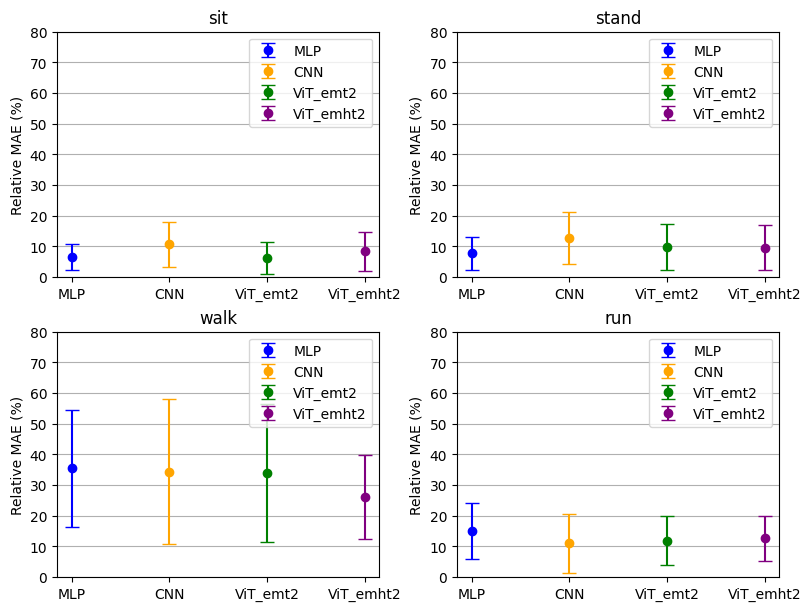

In [11]:
evaluate_models_action_relative(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)